In [2]:
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import probdownscale
#reload(probdownscale.TaskExtractor)
#reload(probdownscale.MetaTrain)
from probdownscale.MetaTrain import MetaSGD

from probdownscale.TaskExtractor import TaskExtractor
import math
import numpy as np
import netCDF4 as nc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from matplotlib import pyplot as plt

C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\96349\anaconda3\env

## 1. Debug TaskExtractor

In [16]:
file_path_g_05 = r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20050516-20060515.nc'
file_path_g_06 =  r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20060516-20070515.nc'
file_path_m = r'C:\Users\96349\Documents\Downscale_data\MERRA2\MERRA2_aerosol_variables_over_MiddleEast_daily_20000516-20180515.nc'
target_var = 'BCSMASS'

# read data
g05_data = nc.Dataset(file_path_g_05)
g06_data = nc.Dataset(file_path_g_06)
m_data_nc = nc.Dataset(file_path_m)

# define lat&lon of MERRA, G5NR and mete
M_lons = m_data_nc.variables['lon'][:15]
# self.M_lons = (M_lons-M_lons.mean())/M_lons.std()
M_lats = m_data_nc.variables['lat'][:15]
# self.M_lats = (M_lats-M_lats.mean())/M_lats.std()
G_lons = g05_data.variables['lon'][:30]
# self.G_lons = (G_lons-G_lons.mean())/G_lons.std()
G_lats = g05_data.variables['lat'][:30]

# extract target data
g_data = np.concatenate((g05_data.variables[target_var][:, :30, :30], g06_data.variables[target_var][:, :30, :30]), axis=0)
m_data = m_data_nc.variables[target_var][5*365:7*365, :15, :15]

C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packag

In [17]:
train_g_data, test_g_data = g_data[:657], g_data[657:]
train_m_data, test_m_data = m_data[:657], m_data[657:]
data = [train_g_data, train_m_data]
lats_lons = [G_lats, G_lons, M_lats, M_lons]
task_dim = 5
test_proportion = 0.4
n_lag = 15
taskextractor = TaskExtractor(data, lats_lons, task_dim, test_proportion, n_lag)

In [18]:
train_x, train_y, test_x, test_y, location = taskextractor._get_one_random_task(return_init=False, is_seq=True)

In [29]:
train_x[0].shape

(383, 20, 5, 5, 1)

In [40]:
mat = np.zeros((5,5))
np.expand_dims(mat, [0,1, -1]).shape

(1, 1, 5, 5, 1)

In [25]:
train_x, train_y, test_x, test_y, locations = taskextractor.get_random_tasks(10)


In [35]:
train_x, train_y, test_x, test_y, locations = taskextractor.get_random_tasks(locations=locations[:4])

## 2. Test Network

In [40]:
# the last channel is the comonents
alphas = np.array([0.1, 0.2, 0.3], dtype='float32')
mus = np.random.rand(3, 3, 3, 3)
sigmas = np.ones((3,3, 3,3))
gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphas),
        components_distribution=tfd.Independent(tfd.Gamma(concentration=mus.astype('float32'), 
                                                          rate=sigmas.astype('float32')),
                                                reinterpreted_batch_ndims=2))

In [41]:
gm

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[3] event_shape=[3, 3] dtype=float32>

In [32]:
sigma = sigmas.astype('float32')

In [36]:
gm.log_prob(tf.cast(sigmas, tf.float32))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-52.2113, -52.2113, -52.2113, -52.2113], dtype=float32)>

In [130]:
gm.log_prob(np.random.rand(10, 10))

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[-0.81677365, -0.7552407 , -0.665617  , -0.0764401 , -0.25152075,
        -0.9879017 , -0.812474  , -0.12412405, -0.21668303, -0.30930328],
       [-0.29921353, -0.495041  , -0.6167681 , -0.23526359, -0.786206  ,
        -0.6638526 , -0.8141794 , -0.41877592, -0.45961   , -0.5047138 ],
       [-0.20135546, -0.01736981, -0.87274444, -0.848408  , -0.18358684,
        -0.24106824, -0.75043106, -0.44442248, -0.04535139, -0.13121045],
       [-0.00426078, -0.04229522, -0.10431826, -0.00649816, -0.39125276,
        -0.00358528, -0.28281736, -0.679108  , -0.8104651 , -0.7005278 ],
       [-0.7986145 , -0.19821668, -0.3713138 , -0.36503458, -0.5757148 ,
        -0.7432246 , -0.35033762, -0.30271828, -0.43028128, -0.71609855],
       [-0.5522039 , -0.16613245, -0.53208804, -0.78406143, -0.36748087,
        -0.04784411, -0.68711877, -0.9483013 , -0.23533762, -0.8653908 ],
       [-0.7508776 , -0.3697071 , -0.20990872, -0.1310147 , -0.74804

In [96]:
test_md.prob(np.random.rand(32, 3, 3)/1000)

<tf.Tensor: shape=(32, 3, 3), dtype=float64, numpy=
array([[[0.25923411, 0.25941254, 0.25940204],
        [0.25940951, 0.25936596, 0.25929402],
        [0.2594633 , 0.25939314, 0.25936692]],

       [[0.51305619, 0.51302286, 0.51243822],
        [0.51209399, 0.51288136, 0.51219623],
        [0.51208175, 0.5127574 , 0.51282095]],

       [[0.45361849, 0.45362546, 0.45401628],
        [0.45403016, 0.45362778, 0.45357959],
        [0.45398947, 0.45434852, 0.45409695]],

       [[0.57532472, 0.57589357, 0.57605025],
        [0.5766248 , 0.5757438 , 0.57629886],
        [0.5760932 , 0.57664341, 0.57553385]],

       [[0.66776946, 0.6676033 , 0.66801849],
        [0.66747887, 0.6669458 , 0.66839222],
        [0.66755283, 0.66818148, 0.66803568]],

       [[0.43061094, 0.43118904, 0.43129869],
        [0.43109465, 0.43100402, 0.43104042],
        [0.43082529, 0.43126773, 0.43095325]],

       [[1.21996287, 1.21667833, 1.21746689],
        [1.22200614, 1.21967749, 1.21878564],
        [1.21882

In [86]:
test_md

<tfp.distributions.Normal 'Normal' batch_shape=[1] event_shape=[] dtype=float64>

In [12]:
tf.clip_by_value(test_md.log_prob(mu/100000), clip_value_min=-10000, clip_value_max=0)

NameError: name 'inf' is not defined

In [94]:
train_y.mean()

0.02247035575477696

In [11]:
mu/100000

array([[6.06267399e-06, 2.13926465e-06],
       [3.74470503e-06, 7.62868998e-06],
       [5.65969330e-06, 5.92068217e-06]])

In [80]:
log_like = test_md.log_prob(np.ones((3, 3,2)))
#-tf.reduce_mean(log_like, axis=-1)
log_like

# when the Y is really small, log_prob return a positive log likelihood

NameError: name 'test_md' is not defined

In [313]:
test_md.mean()

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[0.15880819, 0.10569395],
       [0.17997603, 0.15908541],
       [0.20016422, 0.19627221]])>

In [42]:
# define necessary tool functions
num_components = 500

def nnelu(input):
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))
tf.keras.utils.get_custom_objects().update({'nnelu': layers.Activation(nnelu)})

def slice_parameter_vectors(parameter_vector):
    alphas = parameter_vector[:, :num_components]
    mus = parameter_vector[:, num_components:(num_components*(task_dim*task_dim+1))]
    sigmas = parameter_vector[:, (num_components*(task_dim*task_dim+1)):]
    return alphas, mus, sigmas

def res_loss(y, parameter_vector):
    alphas, mus, sigmas = slice_parameter_vectors(parameter_vector)
    mus = tf.reshape(mus, (tf.shape(mus)[0], num_components, task_dim, task_dim))
    sigmas = tf.reshape(sigmas, (tf.shape(sigmas)[0], num_components, task_dim, task_dim))
    gm =tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphas),
        components_distribution=tfd.Independent(tfd.Gamma(concentration=mus, rate=sigmas), reinterpreted_batch_ndims=2) )
    #print('Y shape:', tf.shape(y))
    #print('Transpose Y shape:', tf.shape(tf.transpose(y)))
    log_likelihood = tf.clip_by_value(gm.log_prob(tf.cast(y, tf.float32)), clip_value_min=-10000, clip_value_max=0)
    return -tf.reduce_mean(log_likelihood)



def plot_history(history, title):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(title)
    
def model_generator():
    # define MDN Exponentialmodel
    # input dim (time, channel, rows, cols)
    input1 = layers.Input(shape=(n_lag, task_dim, task_dim, 1), dtype='float32') 
    input1 = layers.BatchNormalization()(input1)
    input2 = layers.Input(shape=(task_dim, task_dim, 1), dtype='float32')
    input2 = layers.BatchNormalization()(input2)
    input3 = layers.Input(shape=(1, ), dtype='float32')
    input3 = layers.BatchNormalization()(input3)

    X = layers.ConvLSTM2D(filters=50, kernel_size=(3,3), padding='same', activation='tanh', return_sequences=True)(input1)
    #X = layers.ConvLSTM2D(filters=50, kernel_size=(3,3), padding='same', activation='tanh', return_sequences=True)(X)
    #X = layers.ConvLSTM2D(filters=50, kernel_size=(3,3), padding='same', activation='tanh', return_sequences=True)(X)
    #X = layers.ConvLSTM2D(filters=50, kernel_size=(3,3), padding='same', activation='tanh', return_sequences=True)(X)
    #X = layers.ConvLSTM2D(filters=50, kernel_size=(1,2), padding='same', activation='tanh', return_sequences=True)(X)
    #X = layers.ConvLSTM2D(filters=50, kernel_size=(1,2), padding='same', activation='tanh', return_sequences=True)(X)
    #X = layers.ConvLSTM2D(filters=50, kernel_size=(1,2), padding='same', activation='selu', return_sequences=True)(X)
    #X = layers.ConvLSTM2D(filters=50, kernel_size=(1,2), padding='same', activation='tanh', return_sequences=True)(X)
    #X = layers.ConvLSTM2D(filters=50, kernel_size=(1,2), padding='same', activation='tanh', return_sequences=True)(X)
    X = layers.ConvLSTM2D(filters=50, kernel_size=(1,1), activation='tanh')(X)
    X = layers.Flatten()(X)
    X = layers.Dense(128)(X)
    X = layers.LeakyReLU(alpha=0.05)(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128)(X)
    X = layers.LeakyReLU(alpha=0.05)(X)

    X1 = layers.Conv2D(20, (2,2), activation='relu')(input2)
    X1 = layers.Flatten()(X1)
    X2 = layers.BatchNormalization()(input3)

    X = layers.Concatenate()([X, X1, X2])
    X = layers.Dense(128)(X)
    X = layers.LeakyReLU(alpha=0.05)(X)
    X = layers.BatchNormalization()(X)

    #Y = layers.Dense(task_dim*task_dim, activation='nnelu')(X)
    #output = layers.Reshape((3, 3))(Y)
    
    
    alphas1 = layers.Dense(num_components, activation="softmax")(X)
    mus1 = layers.Dense(num_components*task_dim*task_dim, activation='nnelu')(X)
    sigmas1 = layers.Dense(num_components*task_dim*task_dim, activation='nnelu')(X)
    
    output = layers.Concatenate()([alphas1, mus1, sigmas1])
    
    model = Model([input1, input2, input3], output)
    return model

In [62]:
MDN_model_ref_gamma.save_weights(r'MDN_model_weights')

In [66]:
MDN_model_ref_gamma.load_weights(r'MDN_model_weights')

Epoch 1/40
13/13 [==============================] - 10s 316ms/step - loss: 1.3514 - val_loss: 2.6067 - lr: 0.0010
Epoch 2/40
13/13 [==============================] - 3s 268ms/step - loss: 0.3988 - val_loss: 2.4922 - lr: 0.0010
Epoch 3/40
13/13 [==============================] - 4s 276ms/step - loss: 0.1479 - val_loss: 2.3138 - lr: 0.0010
Epoch 4/40
13/13 [==============================] - 3s 266ms/step - loss: 0.0835 - val_loss: 1.9353 - lr: 0.0010
Epoch 5/40
13/13 [==============================] - 3s 262ms/step - loss: 0.0495 - val_loss: 1.6820 - lr: 0.0010
Epoch 6/40
13/13 [==============================] - 3s 262ms/step - loss: 0.0293 - val_loss: 1.6156 - lr: 0.0010
Epoch 7/40
13/13 [==============================] - 3s 260ms/step - loss: 0.0149 - val_loss: 1.5020 - lr: 0.0010
Epoch 8/40
13/13 [==============================] - 3s 262ms/step - loss: 0.0197 - val_loss: 1.4545 - lr: 0.0010
Epoch 9/40
13/13 [==============================] - 4s 272ms/step - loss: 0.0014 - val_loss: 1.

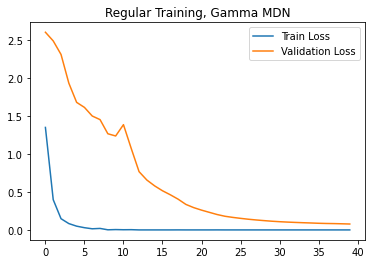

In [43]:
# define MDN Gamma model
MDN_model_ref_gamma = model_generator()
#MDN_model_ref_gamma.set_weights(meta_learner.meta_model.get_weights())
MDN_model_ref_gamma.compile(optimizer=tf.keras.optimizers.Adam(), loss=res_loss)
def scheduler(epoch, lr):
    if epoch <= 10:
        return 0.001
    elif epoch <= 30 and epoch > 10:
        return 0.0005
    else:
        return 0.00001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history_gamma = MDN_model_ref_gamma.fit(train_x, train_y, epochs=40, validation_data=[test_x, test_y], callbacks=callback)
plot_history(history_gamma, 'Regular Training, Gamma MDN')

In [221]:
parameter_vector = MDN_model_ref_gamma(test_x, training=True)
alphas, mus, sigmas = slice_parameter_vectors(parameter_vector)
gm =tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphas),
        components_distribution=tfd.Gamma(concentration=mus, rate=sigmas))
    #print('Y shape:', tf.shape(y))
    #print('Transpose Y shape:', tf.shape(tf.transpose(y)))


In [246]:
tf.cast(tf.transpose(test_y), tf.float32)

<tf.Tensor: shape=(3, 3, 254), dtype=float32, numpy=
array([[[0.30244112, 0.31262407, 0.3112915 , ..., 0.1622046 ,
         0.13867684, 0.10402217],
        [0.30334234, 0.31289777, 0.30812722, ..., 0.16051565,
         0.13716146, 0.10336461],
        [0.30282164, 0.31266412, 0.29883465, ..., 0.15930067,
         0.13560268, 0.10245338]],

       [[0.2982955 , 0.3099204 , 0.3103235 , ..., 0.16219458,
         0.13797255, 0.10332789],
        [0.29975748, 0.31043443, 0.3066185 , ..., 0.16043888,
         0.13710472, 0.10282388],
        [0.29937696, 0.31020078, 0.29582393, ..., 0.15897356,
         0.13594314, 0.10232988]],

       [[0.29493096, 0.30855855, 0.30607778, ..., 0.16224799,
         0.13699123, 0.1025168 ],
        [0.29597238, 0.30900583, 0.303027  , ..., 0.16023861,
         0.13608667, 0.10188594],
        [0.29623273, 0.30901918, 0.29365432, ..., 0.15860975,
         0.13531896, 0.10149208]]], dtype=float32)>

In [247]:
gm.log_prob(tf.cast(tf.transpose(test_y), tf.float32))

<tf.Tensor: shape=(3, 3, 254), dtype=float32, numpy=
array([[[-0.07328892, -0.09322166, -0.09237862, ...,  0.23675871,
          0.3116927 ,  0.4281187 ],
        [-0.07453823, -0.09361219, -0.08780622, ...,  0.24175215,
          0.31648827,  0.43046904],
        [-0.0738163 , -0.09327888, -0.07439899, ...,  0.24535894,
          0.32144785,  0.43373966]],

       [[-0.06754827, -0.08936501, -0.09097958, ...,  0.23678827,
          0.3139181 ,  0.43060017],
        [-0.0695715 , -0.09009838, -0.08562708, ...,  0.2419796 ,
          0.31666803,  0.43240786],
        [-0.06904459, -0.08976507, -0.07006216, ...,  0.24633217,
          0.3203621 ,  0.43418407]],

       [[-0.06289816, -0.0874238 , -0.0848465 , ...,  0.23663044,
          0.31702852,  0.43351126],
        [-0.06433678, -0.08806133, -0.08044386, ...,  0.24257326,
          0.3199048 ,  0.43578434],
        [-0.06469631, -0.08808041, -0.06693935, ...,  0.24741554,
          0.32235384,  0.4372077 ]]], dtype=float32)>

In [44]:
pred_y = MDN_model_ref_gamma.predict(test_x)

In [48]:
pred_y_sample = predict_real(pred_y)

In [47]:
def predict_real(pred_y):
    alphas, mus, sigmas = slice_parameter_vectors(pred_y)
    mus = tf.reshape(mus, (tf.shape(mus)[0], num_components, task_dim, task_dim))
    sigmas = tf.reshape(sigmas, (tf.shape(sigmas)[0], num_components, task_dim, task_dim))
    gm =tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alphas),
        components_distribution=tfd.Independent(tfd.Gamma(concentration=mus, rate=sigmas), reinterpreted_batch_ndims=2) )
    return gm

In [50]:
pred_y_sample.sample()

<tf.Tensor: shape=(256, 5, 5), dtype=float32, numpy=
array([[[8.0091387e-01, 6.0245238e-02, 3.9594054e-01, 1.3282707e-01,
         1.9656484e-01],
        [4.3902244e-02, 4.5054495e-02, 1.2089683e+00, 2.7984474e-02,
         1.2830240e-02],
        [1.0315001e+00, 1.0515459e+00, 7.0888263e-01, 2.3281953e+00,
         3.5499190e-03],
        [1.0619958e-01, 5.7571005e-02, 1.6360493e-01, 9.8119266e-02,
         1.6817088e-01],
        [2.8247342e-01, 7.3146962e-02, 7.1314937e-01, 6.5933484e-01,
         2.9059109e-01]],

       [[5.0314164e-01, 2.5809056e-01, 4.5471919e-01, 4.6757951e-01,
         7.8857964e-01],
        [4.3630764e-01, 2.2813885e+00, 6.8821394e-01, 1.0448570e+00,
         5.1023281e-01],
        [2.2620862e+00, 1.4975916e+00, 1.3412184e+00, 4.7135830e-01,
         1.7609988e+00],
        [1.2284186e+00, 3.8132614e-01, 1.7573929e+00, 1.1428331e+00,
         1.7438525e+00],
        [8.1288570e-01, 1.2676257e-01, 2.8229862e-01, 1.8408259e+00,
         1.2352164e+00]],

   

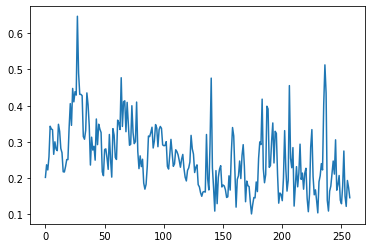

In [198]:
plt.plot(test_y[:, 2, 2])

In [28]:
y_hat = MDN_model_ref_gamma.predict(test_x)

In [16]:
y_hat.shape

(194, 3, 3)

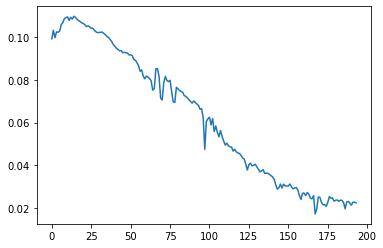

(array([33., 22., 19., 14., 10., 16., 20.,  8., 19., 33.]),
 array([0.01731259, 0.02655789, 0.03580319, 0.04504849, 0.05429379,
        0.06353909, 0.07278439, 0.08202969, 0.09127499, 0.10052029,
        0.10976559], dtype=float32),
 <BarContainer object of 10 artists>)

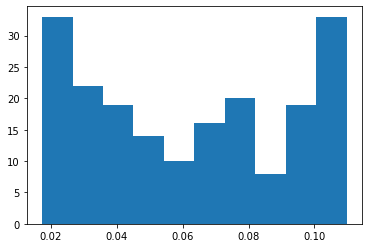

In [29]:
plt.plot(y_hat[:, 0, 0])
plt.show()
plt.hist(y_hat[:, 0, 0])

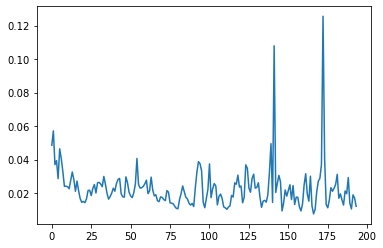

(array([81., 88., 19.,  3.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([0.00756108, 0.01935825, 0.03115543, 0.0429526 , 0.05474977,
        0.06654694, 0.07834411, 0.09014129, 0.10193846, 0.11373563,
        0.1255328 ]),
 <BarContainer object of 10 artists>)

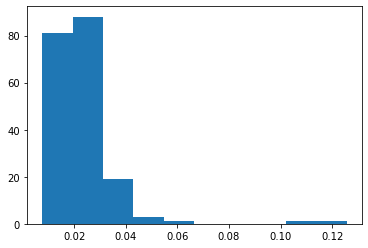

In [30]:
plt.plot(test_y[:, 0, 0])
plt.show()
plt.hist(test_y[:, 0, 0])

## 3. Debug Meta Learning Algorithm

In [47]:
reload(probdownscale.MetaTrain)
from probdownscale.MetaTrain import MetaSGD

# define necessary tool functions
components = 500
data = [train_g_data, train_m_data]
lats_lons = [G_lats, G_lons, M_lats, M_lons]
task_dim = 5
test_proportion = 0.5
n_lag = 20

MDN_model = model_generator(components, )

# define TaskExtractor

taskextractor = TaskExtractor(data, lats_lons, task_dim, test_proportion, n_lag)

# define meta learner
meta_optimizer = tf.keras.optimizers.Adam(0.001)
inner_step = 1
inner_optimizer = tf.keras.optimizers.Adam(0.001)

meta_learner = MetaSGD(MDN_model, res_loss,  meta_optimizer, inner_step, inner_optimizer, taskextractor, meta_lr=0.005)


TypeError: model_generator() takes 0 positional arguments but 1 was given

$\beta = lr\times e^{-\bar{Cov}}\times (e^{(b/s)^{0.5}}-1)$

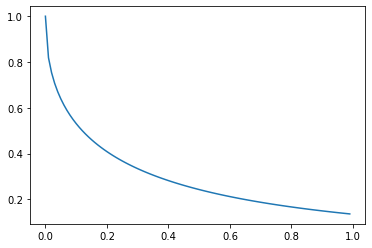

In [45]:
# Cov factor
x = np.array(list(range(100)))/100
y = np.exp(-2*x**0.5)
plt.plot(x, y)

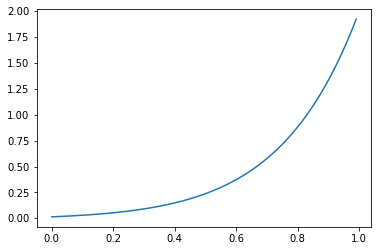

In [57]:
# batch factor
x = np.array(list(range(100)))/100
y = np.exp(5*x**0.8)*2/np.exp(5)
plt.plot(x, y)

In [12]:
from math import exp, sqrt, log
def covariance_function(h, phi=0.5):
    return exp(-h/phi)

def distance_function(loc1, loc2):
    return sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

def beta_function(meta_rate, batch_locations, seen_locations, covariance_function, distance_function):
    batch_size = len(batch_locations)
    seen_size = len(seen_locations.items())
    if seen_size == 0:
        return meta_rate
    temp = 0
    for b_loc in batch_locations:
        for s_loc, n in seen_locations.items():
            cov = covariance_function(distance_function(b_loc, s_loc))
            temp += cov * (1 + log(n))
    mean_cov = temp/(batch_size*sum(list(seen_locations.values())))
    cov_factor = exp(-mean_cov**0.5)
    bsize_factor = exp((batch_size/seen_size)**0.5)-1
    print('covariance factor:', cov_factor)
    print('batch size factor:', exp((batch_size/seen_size)**0.1)-1)
    lr = meta_rate*bsize_factor*cov_factor
    return lr

# meta train with beta
meta_history = meta_learner.meta_fit(10, batch_size=10, basic_train=True, bootstrap_train=True, use_test_for_meta=True, randomize=True,
                                    beta_function=beta_function, covariance_function=covariance_function, distance_function=distance_function)
plt.plot(meta_history)
plt.title('Meta Training with Beta History')
plt.show()

covariance factor: 0.5741991021729458
batch size factor: 1.718281828459045
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0049331794>
Epoch: 1 / 10  Basic training step:  1 / 8 loss:  0.23606083
covariance factor: 0.582689115549577
batch size factor: 1.5422079918208849
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0029953572>
Epoch: 1 / 10  Basic training step:  2 / 8 loss:  0.13980743
covariance factor: 0.6061128560526277
batch size factor: 1.449682587009316
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0023678169>
Epoch: 1 / 10  Basic training step:  3 / 8 loss:  0.0995484
covariance factor: 0.6125017411975265
batch size factor: 1.3882253608578883
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0019867145>
Epoch: 1 / 10  Basic training step:  4 / 8 loss:  0.0777386
covariance factor: 0.6096929938091851
batch size factor: 1.3427838986640035
Meta lr: <tf.Variable 'learning_rate:0' shape

KeyboardInterrupt: 

In [7]:
MDN_model_wo_beta = model_generator()
inner_optimizer_wob = tf.keras.optimizers.Adam(0.001)
meta_optimizer_wob = tf.keras.optimizers.Adam(0.001)
meta_learner_wo_beta = MetaSGD(MDN_model_wo_beta, res_loss,  meta_optimizer_wob, inner_step, inner_optimizer_wob, taskextractor)
# meta train
meta_history_wob = meta_learner_wo_beta.meta_fit(10, batch_size=10, basic_train=True, bootstrap_train=True, use_test_for_meta=True, randomize=True)
plt.plot(meta_history_wob, "-b", label="without beta")
plt.title('Meta Training Without Beta History ')
plt.show()

NameError: name 'model_generator' is not defined

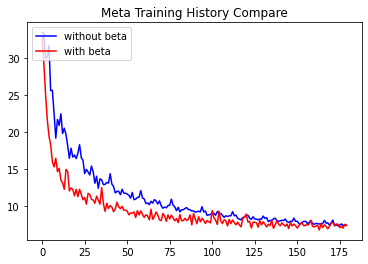

In [233]:
plt.plot(meta_history_wob, "-b", label="without beta")
plt.plot(meta_history, "-r", label="with beta")
plt.legend(loc="upper left")
plt.title('Meta Training History Compare')
plt.show()

In [55]:
meta_learner.meta_model.set_weights(meta_weights)

In [16]:
meta_weights = meta_learner.meta_model.get_weights()
trained_meta_model = meta_learner.meta_model
optimizer = tf.keras.optimizers.Adam(0.000001)
trained_meta_model.compile(optimizer=optimizer, loss=gamma_loss)
meta_history_fine_tune = trained_meta_model.fit(train_x, train_y, epochs=30, validation_data=[test_x, test_y])
meta_learner.meta_model.set_weights(meta_weights)

Epoch 1/30
16/16 [==============================] - 12s 97ms/step - loss: 5.9748 - val_loss: 6.7861
Epoch 2/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9655 - val_loss: 6.4503
Epoch 3/30
16/16 [==============================] - 1s 31ms/step - loss: 6.0707 - val_loss: 6.3228
Epoch 4/30
16/16 [==============================] - 0s 31ms/step - loss: 6.0438 - val_loss: nan
Epoch 5/30
16/16 [==============================] - 0s 31ms/step - loss: 5.9490 - val_loss: nan
Epoch 6/30
16/16 [==============================] - 0s 31ms/step - loss: 5.9490 - val_loss: nan
Epoch 7/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9713 - val_loss: nan
Epoch 8/30
16/16 [==============================] - 0s 31ms/step - loss: 5.9675 - val_loss: nan
Epoch 9/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9840 - val_loss: nan
Epoch 10/30
16/16 [==============================] - 1s 31ms/step - loss: 5.9684 - val_loss: nan
Epoch 11/30
16/16 [==========

In [57]:
# Bayesian NN
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model



In [78]:
layer_dims = [32, 32]
input1 = layers.Input(shape=(n_lag, 1, task_dim, task_dim)) 
input1 = layers.BatchNormalization()(input1)
input2 = layers.Input(shape=(task_dim, task_dim, 1))
input2 = layers.BatchNormalization()(input2)
input3 = layers.Input(shape=(1, ))
X2 = layers.BatchNormalization()(input3)

X = layers.ConvLSTM2D(filters=50, kernel_size=(1,2), padding='same', activation='tanh', return_sequences=True)(input1)
#X = layers.ConvLSTM2D(filters=50, kernel_size=(1,2), padding='same', activation='tanh', return_sequences=True)(X)
#X = layers.ConvLSTM2D(filters=50, kernel_size=(1,2), padding='same', activation='tanh', return_sequences=True)(X)
X = layers.ConvLSTM2D(filters=50, kernel_size=(1,1), activation='tanh')(X)
X = layers.Flatten()(X)

X1 = layers.Conv2D(20, (2,2), activation='relu')(input2)
X1 = layers.Flatten()(X1)

X = layers.Concatenate()([X, X1, X2])
for dim in layer_dims:
    X = tfp.layers.DenseVariational(
                units=dim,
                make_prior_fn=prior,
                make_posterior_fn=posterior,
                kl_weight=1 / 50,
                activation="relu",
            )(X)
X = layers.Dense(9, activation='nnelu')(X)
output = layers.Reshape([3,3])(X)
model = Model([input1, input2, input3], output)
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001), loss='mse')
def scheduler(epoch, lr):
    if epoch <= 5:
        return 0.0001
    elif epoch <= 20 and epoch > 5:
        return 0.00005
    else:
        return 0.000005
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_x, train_y, epochs=200, validation_data=[test_x, test_y])
plot_history(history, 'Regular Training, BNN')

Epoch 1/200
15/15 [==============================] - 31s 2s/step - loss: 24.4379 - val_loss: 58.5531
Epoch 2/200
15/15 [==============================] - 22s 1s/step - loss: 22.6720 - val_loss: 33.8185
Epoch 3/200
15/15 [==============================] - 22s 1s/step - loss: 22.4391 - val_loss: 29.3915
Epoch 4/200
15/15 [==============================] - 22s 1s/step - loss: 23.0425 - val_loss: 32.4563
Epoch 5/200
15/15 [==============================] - 22s 1s/step - loss: 23.5784 - val_loss: 28.4635
Epoch 6/200
15/15 [==============================] - 23s 2s/step - loss: 23.7742 - val_loss: 26.1959
Epoch 7/200
15/15 [==============================] - 22s 1s/step - loss: 22.6203 - val_loss: 21.9650
Epoch 8/200
15/15 [==============================] - 22s 1s/step - loss: 23.4167 - val_loss: 23.2346
Epoch 9/200
15/15 [==============================] - 22s 1s/step - loss: 23.1896 - val_loss: 21.9619
Epoch 10/200
15/15 [==============================] - 22s 1s/step - loss: 22.6556 - val_los

KeyboardInterrupt: 

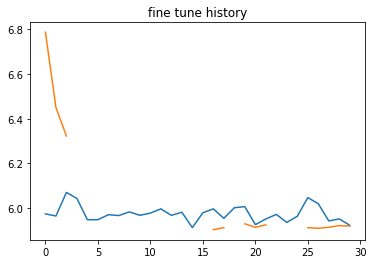

In [17]:
plot_history(meta_history_fine_tune, 'fine tune history')

In [39]:
trained_meta_model = meta_learner.meta_model
untrainded_weights = trained_meta_model.get_weights()

In [42]:
loc1 = [1, 1]
loc2 = [2, 2]
(loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2

2

In [46]:
for i, j in a.items():
    print(i, j)

a 1
b 2


Text(0.5, 1.0, 'Meta Training History')

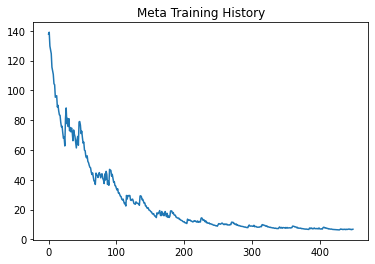

In [66]:
plt.plot(meta_history)
plt.title('Meta Training History')

In [69]:
trained_meta_model = meta_learner.meta_model
optimizer = tf.keras.optimizers.Adam(0.0000001)
trained_meta_model.compile(optimizer=optimizer, loss=gamma_loss)
trained_meta_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_148 (InputLayer)         [(None, 10, 1, 3, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_lstm2d_72 (ConvLSTM2D)    (None, 10, 1, 2, 20  3760        ['input_148[0][0]']              
                                )                                                                 
                                                                                                  
 conv_lstm2d_73 (ConvLSTM2D)    (None, 10, 1, 1, 20  6480        ['conv_lstm2d_72[1][0]']         
                                )                                                          

In [31]:
meta_history_fine_tune = trained_meta_model.fit(train_x, train_y, epochs=10)

Epoch 1/10
15/15 [==============================] - 0s 31ms/step - loss: 5.7476
Epoch 2/10
15/15 [==============================] - 0s 31ms/step - loss: 5.7670
Epoch 3/10
15/15 [==============================] - 0s 31ms/step - loss: 5.7426
Epoch 4/10
15/15 [==============================] - 0s 31ms/step - loss: 5.8128
Epoch 5/10
15/15 [==============================] - 0s 29ms/step - loss: 5.7806
Epoch 6/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8076
Epoch 7/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8419
Epoch 8/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8233
Epoch 9/10
15/15 [==============================] - 0s 28ms/step - loss: 5.8088
Epoch 10/10
15/15 [==============================] - 0s 28ms/step - loss: 5.7748


## 4. Debug Downscaler

In [72]:
reload(probdownscale.Downscaler)
from probdownscale.Downscaler import Downscaler


In [159]:
downscaler = Downscaler(meta_learner, components, test_m_data)
optimizer = tf.keras.optimizers.Adam(0.0000001)
downscaled_data = downscaler.downscale(30, optimizer, n_sample=100)

Epoch 1/30
21/21 [==============================] - 12s 70ms/step - loss: 7.0227
Epoch 2/30
21/21 [==============================] - 1s 70ms/step - loss: 6.8977
Epoch 3/30
21/21 [==============================] - 2s 75ms/step - loss: 6.9414
Epoch 4/30
21/21 [==============================] - 2s 86ms/step - loss: 6.9062
Epoch 5/30
21/21 [==============================] - 2s 86ms/step - loss: 6.9783
Epoch 6/30
21/21 [==============================] - 2s 85ms/step - loss: 6.9534
Epoch 7/30
21/21 [==============================] - 2s 86ms/step - loss: 6.9184
Epoch 8/30
21/21 [==============================] - 2s 86ms/step - loss: 6.8386
Epoch 9/30
21/21 [==============================] - 2s 91ms/step - loss: 6.9550
Epoch 10/30
21/21 [==============================] - 2s 89ms/step - loss: 6.9486
Epoch 11/30
21/21 [==============================] - 2s 88ms/step - loss: 6.9090
Epoch 12/30
21/21 [==============================] - 2s 86ms/step - loss: 6.9085
Epoch 13/30
21/21 [=================

21/21 [==============================] - 2s 84ms/step - loss: 6.9905
Epoch 24/30
21/21 [==============================] - 2s 83ms/step - loss: 6.9435
Epoch 25/30
21/21 [==============================] - 2s 82ms/step - loss: 6.8508
Epoch 26/30
21/21 [==============================] - 2s 83ms/step - loss: 6.9873
Epoch 27/30
21/21 [==============================] - 2s 83ms/step - loss: 6.8902
Epoch 28/30
21/21 [==============================] - 2s 83ms/step - loss: 6.7896
Epoch 29/30
21/21 [==============================] - 2s 85ms/step - loss: 6.8500
Epoch 30/30
21/21 [==============================] - 2s 86ms/step - loss: 6.8534
Epoch 1/30
21/21 [==============================] - 2s 82ms/step - loss: 6.7637
Epoch 2/30
21/21 [==============================] - 2s 89ms/step - loss: 6.6975
Epoch 3/30
21/21 [==============================] - 2s 83ms/step - loss: 6.7411
Epoch 4/30
21/21 [==============================] - 2s 83ms/step - loss: 6.8505
Epoch 5/30
21/21 [==========================

21/21 [==============================] - 2s 83ms/step - loss: 6.8563
Epoch 16/30
21/21 [==============================] - 2s 84ms/step - loss: 6.7874
Epoch 17/30
21/21 [==============================] - 2s 83ms/step - loss: 6.7972
Epoch 18/30
21/21 [==============================] - 2s 83ms/step - loss: 6.7755
Epoch 19/30
21/21 [==============================] - 2s 83ms/step - loss: 6.8277
Epoch 20/30
21/21 [==============================] - 2s 84ms/step - loss: 6.9009
Epoch 21/30
21/21 [==============================] - 2s 85ms/step - loss: 6.7628
Epoch 22/30
21/21 [==============================] - 2s 83ms/step - loss: 6.8096
Epoch 23/30
21/21 [==============================] - 2s 84ms/step - loss: 6.8575
Epoch 24/30
21/21 [==============================] - 2s 84ms/step - loss: 6.8298
Epoch 25/30
21/21 [==============================] - 2s 84ms/step - loss: 6.8247
Epoch 26/30
21/21 [==============================] - 2s 84ms/step - loss: 6.8462
Epoch 27/30
21/21 [=====================

21/21 [==============================] - 2s 97ms/step - loss: 6.6485
Epoch 8/30
21/21 [==============================] - 2s 101ms/step - loss: 6.6711
Epoch 9/30
21/21 [==============================] - 2s 102ms/step - loss: 6.7515
Epoch 10/30
21/21 [==============================] - 2s 104ms/step - loss: 6.6153
Epoch 11/30
21/21 [==============================] - 2s 98ms/step - loss: 6.8107
Epoch 12/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6196
Epoch 13/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6304
Epoch 14/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8068
Epoch 15/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7083
Epoch 16/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6269
Epoch 17/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6286
Epoch 18/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5991
Epoch 19/30
21/21 [====================

21/21 [==============================] - 2s 97ms/step - loss: 6.6531
Epoch 30/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6686
Epoch 1/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5871
Epoch 2/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6895
Epoch 3/30
21/21 [==============================] - 2s 114ms/step - loss: 6.5290
Epoch 4/30
21/21 [==============================] - 2s 105ms/step - loss: 6.5247
Epoch 5/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7003
Epoch 6/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5961
Epoch 7/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6194
Epoch 8/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6243
Epoch 9/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6296
Epoch 10/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6291
Epoch 11/30
21/21 [============================

21/21 [==============================] - 2s 96ms/step - loss: 6.8289
Epoch 22/30
21/21 [==============================] - 2s 98ms/step - loss: 6.8809
Epoch 23/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6907
Epoch 24/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8984
Epoch 25/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7678
Epoch 26/30
21/21 [==============================] - 2s 97ms/step - loss: 6.9762
Epoch 27/30
21/21 [==============================] - 2s 96ms/step - loss: 6.8849
Epoch 28/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8757
Epoch 29/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8232
Epoch 30/30
21/21 [==============================] - 2s 96ms/step - loss: 6.8361
Epoch 1/30
21/21 [==============================] - 2s 95ms/step - loss: 6.7140
Epoch 2/30
21/21 [==============================] - 2s 96ms/step - loss: 6.8068
Epoch 3/30
21/21 [========================

21/21 [==============================] - 2s 96ms/step - loss: 6.9262
Epoch 14/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8093
Epoch 15/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8368
Epoch 16/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7053
Epoch 17/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8119
Epoch 18/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8337
Epoch 19/30
21/21 [==============================] - 2s 97ms/step - loss: 6.9215
Epoch 20/30
21/21 [==============================] - 2s 96ms/step - loss: 6.7626
Epoch 21/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7700
Epoch 22/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7794
Epoch 23/30
21/21 [==============================] - 2s 102ms/step - loss: 6.7941
Epoch 24/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6734
Epoch 25/30
21/21 [====================

Epoch 5/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4791
Epoch 6/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4530
Epoch 7/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5080
Epoch 8/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5040
Epoch 9/30
21/21 [==============================] - 2s 96ms/step - loss: 6.4554
Epoch 10/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4345
Epoch 11/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4791
Epoch 12/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3637
Epoch 13/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4124
Epoch 14/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4851
Epoch 15/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5740
Epoch 16/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4421
Epoch 17/30
21/21 [==============

21/21 [==============================] - 2s 96ms/step - loss: 6.5609
Epoch 28/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4259
Epoch 29/30
21/21 [==============================] - 2s 102ms/step - loss: 6.4353
Epoch 30/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4475
Epoch 1/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6090
Epoch 2/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6123
Epoch 3/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7081
Epoch 4/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6464
Epoch 5/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5214
Epoch 6/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6349
Epoch 7/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5889
Epoch 8/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5293
Epoch 9/30
21/21 [=============================

21/21 [==============================] - 2s 96ms/step - loss: 6.6256
Epoch 20/30
21/21 [==============================] - 2s 96ms/step - loss: 6.6377
Epoch 21/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6797
Epoch 22/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6062
Epoch 23/30
21/21 [==============================] - 2s 98ms/step - loss: 6.7216
Epoch 24/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6883
Epoch 25/30
21/21 [==============================] - 2s 108ms/step - loss: 6.6139
Epoch 26/30
21/21 [==============================] - 2s 107ms/step - loss: 6.6890
Epoch 27/30
21/21 [==============================] - 2s 98ms/step - loss: 6.7117
Epoch 28/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7930
Epoch 29/30
21/21 [==============================] - 2s 98ms/step - loss: 6.6857
Epoch 30/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6890
Epoch 1/30
21/21 [====================

21/21 [==============================] - 2s 98ms/step - loss: 6.4851
Epoch 12/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4124
Epoch 13/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3989
Epoch 14/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3256
Epoch 15/30
21/21 [==============================] - 2s 98ms/step - loss: 6.3388
Epoch 16/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3820
Epoch 17/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3881
Epoch 18/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4598
Epoch 19/30
21/21 [==============================] - 2s 98ms/step - loss: 6.3920
Epoch 20/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4376
Epoch 21/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4535
Epoch 22/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5493
Epoch 23/30
21/21 [=====================

21/21 [==============================] - 2s 98ms/step - loss: 6.5827
Epoch 4/30
21/21 [==============================] - 2s 100ms/step - loss: 6.6328
Epoch 5/30
21/21 [==============================] - 2s 99ms/step - loss: 6.6145
Epoch 6/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5082
Epoch 7/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5270
Epoch 8/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5518
Epoch 9/30
21/21 [==============================] - 2s 98ms/step - loss: 6.3992
Epoch 10/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5685
Epoch 11/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4431
Epoch 12/30
21/21 [==============================] - 2s 98ms/step - loss: 6.5687
Epoch 13/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5121
Epoch 14/30
21/21 [==============================] - 2s 98ms/step - loss: 6.4910
Epoch 15/30
21/21 [==========================

21/21 [==============================] - 2s 103ms/step - loss: 6.7847
Epoch 26/30
21/21 [==============================] - 2s 97ms/step - loss: 6.8149
Epoch 27/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6020
Epoch 28/30
21/21 [==============================] - 2s 96ms/step - loss: 6.7317
Epoch 29/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5175
Epoch 30/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6021
Epoch 1/30
21/21 [==============================] - 2s 95ms/step - loss: 6.6417
Epoch 2/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5846
Epoch 3/30
21/21 [==============================] - 2s 97ms/step - loss: 6.7230
Epoch 4/30
21/21 [==============================] - 2s 97ms/step - loss: 6.6437
Epoch 5/30
21/21 [==============================] - 2s 97ms/step - loss: 6.5707
Epoch 6/30
21/21 [==============================] - 2s 98ms/step - loss: 6.7322
Epoch 7/30
21/21 [===========================

21/21 [==============================] - 2s 99ms/step - loss: 6.3644
Epoch 18/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3818
Epoch 19/30
21/21 [==============================] - 2s 102ms/step - loss: 6.3846
Epoch 20/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4347
Epoch 21/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3777
Epoch 22/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4943
Epoch 23/30
21/21 [==============================] - 2s 97ms/step - loss: 6.4582
Epoch 24/30
21/21 [==============================] - 2s 98ms/step - loss: 6.3646
Epoch 25/30
21/21 [==============================] - 2s 96ms/step - loss: 6.5810
Epoch 26/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3439
Epoch 27/30
21/21 [==============================] - 2s 96ms/step - loss: 6.3246
Epoch 28/30
21/21 [==============================] - 2s 97ms/step - loss: 6.3826
Epoch 29/30
21/21 [====================

21/21 [==============================] - 2s 103ms/step - loss: 6.5328
Epoch 9/30
21/21 [==============================] - 2s 94ms/step - loss: 6.4151
Epoch 10/30
21/21 [==============================] - 2s 95ms/step - loss: 6.5300
Epoch 11/30
21/21 [==============================] - 2s 94ms/step - loss: 6.4497
Epoch 12/30
21/21 [==============================] - 2s 95ms/step - loss: 6.4424
Epoch 13/30
21/21 [==============================] - 2s 96ms/step - loss: 6.4149
Epoch 14/30
21/21 [==============================] - 2s 95ms/step - loss: 6.4610
Epoch 15/30
21/21 [==============================] - 2s 95ms/step - loss: 6.3533
Epoch 16/30
21/21 [==============================] - 2s 95ms/step - loss: 6.4430
Epoch 17/30
21/21 [==============================] - 2s 95ms/step - loss: 6.5303
Epoch 18/30
21/21 [==============================] - 2s 95ms/step - loss: 6.4751
Epoch 19/30
21/21 [==============================] - 2s 94ms/step - loss: 6.4000
Epoch 20/30
21/21 [=====================

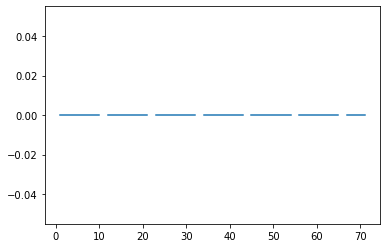

In [154]:
def point_evaluate(pred_data, true_data):
    if pred_data.shape != true_data.shape:
        print('Please check data consistency!')
        raise ValueError
    RMSE_out = np.zeros(pred_data.shape[1:])
    #R2_out = np.zeros(pred_data.shape[1:])
    for i in range(pred_data.shape[1]):
        for j in range(pred_data.shape[2]):
            if np.isnan(true_data[0, i, j]):
                RMSE_out[i, j] = float("nan")
                #R2_out[i, j] = float("nan")
            else:
                RMSE_out[i ,j] = np.square(pred_data[: ,i ,j] - true_data[: ,i ,j]).mean()
                #R2_out[i ,j], _ = nc_process.rsquared(pred_data[: ,i ,j], true_data[: ,i ,j])
    return RMSE_out


def image_evaluate(pred_data, true_data):
    if pred_data.shape != true_data.shape:
        print('Please check data consistency!')
        raise ValueError
    length = np.prod(pred_data.shape[1:])
    r2_list = np.zeros(pred_data.shape[0])
    rmse_list = np.zeros(pred_data.shape[0])
    filter = ~np.isnan(pred_data[0].reshape(length))
    for i in range(pred_data.shape[0]):
        r2_list[i],_ = nc_process.rsquared(pred_data[i].reshape(length)[filter], true_data[i].reshape(length)[filter])
        rmse_list[i] = np.nanmean(np.square(pred_data[i] - true_data[i]))
    return rmse_list, r2_list

In [162]:
downscaled_data[:, 14, 14]

array([7.45737791, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 4.86772442, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 4.90784502, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 4.9520936 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 4.96188164,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       4.77881289, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 5.15625381, 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [26]:
[meta_learner.task_extractor.h_lats[int(i*meta_learner.task_extractor.task_dim[0])] for i in range(int(len(meta_learner.task_extractor.h_lats)//meta_learner.task_extractor.task_dim[0]))]

[10.9375,
 11.125,
 11.3125,
 11.5,
 11.6875,
 11.875,
 12.0625,
 12.25,
 12.4375,
 12.625]

In [69]:
init[0][0, -3:, 0, :, :].shape

(3, 3, 3)